In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR


/home/ai/miniconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
import numpy as np 

DIM = 20 

class FixedRot(datasets.VisionDataset):
    num_targets = 10
    def __init__(self,*args,angle =pi/3,N=50000,size=(7,7),
                 train=True,dataseed=0,**kwargs):
        super().__init__(*args,**kwargs)

        npz = args[0]
        resx = np.linspace(-2., 1., 20)
        self.data = np.zeros([10, 1, DIM, DIM])
        for i in range(0, 10):
            # print(f"{npz[i]}")
            resy = (np.rint(npz[i]*9)).astype(int) // 2
            resy = -resy + 9
            # print(f"{resy}")
            for xi in range(0, DIM):
                self.data[i][0][resy[xi]][xi] = 1.
            # if i == 9:
            #     print(f"i={i}")
            #     print(f"{self.data1[i]}")

        self.data = torch.Tensor(self.data)
        if not train: 
            dataseed += 1
            N = int(0.2*N)
        torch.manual_seed(dataseed)
        angles = torch.ones(N)*angle # torch.rand(N)*2*np.pi
        #self.data = torch.rand(N,1,*size)-.5
        print(N, self.data.shape)
        with torch.no_grad():
            # Build affine matrices for random translation of each image
            affineMatrices = torch.zeros(N,2,3)
            affineMatrices[:,0,0] = angles.cos()
            affineMatrices[:,1,1] = angles.cos()
            affineMatrices[:,0,1] = angles.sin()
            affineMatrices[:,1,0] = -angles.sin()
            # affineMatrices[:,0,2] = -2*np.random.randint(-self.max_trans, self.max_trans+1, bs)/w
            # affineMatrices[:,1,2] = 2*np.random.randint(-self.max_trans, self.max_trans+1, bs)/h
            
            flowgrid = F.affine_grid(affineMatrices, size = self.data.shape) # self.data.size()
            self.data_rot = F.grid_sample(self.data, flowgrid)

    def __getitem__(self,idx):
        return self.data[idx], self.data_rot[idx] # , self.data[idx]
    
    def __len__(self):
        return len(self.data)
    
    def default_aug_layers(self):
        return RandomRotateTranslate(0)# no translation


npz=(10, 20)
10 torch.Size([10, 1, 20, 20])


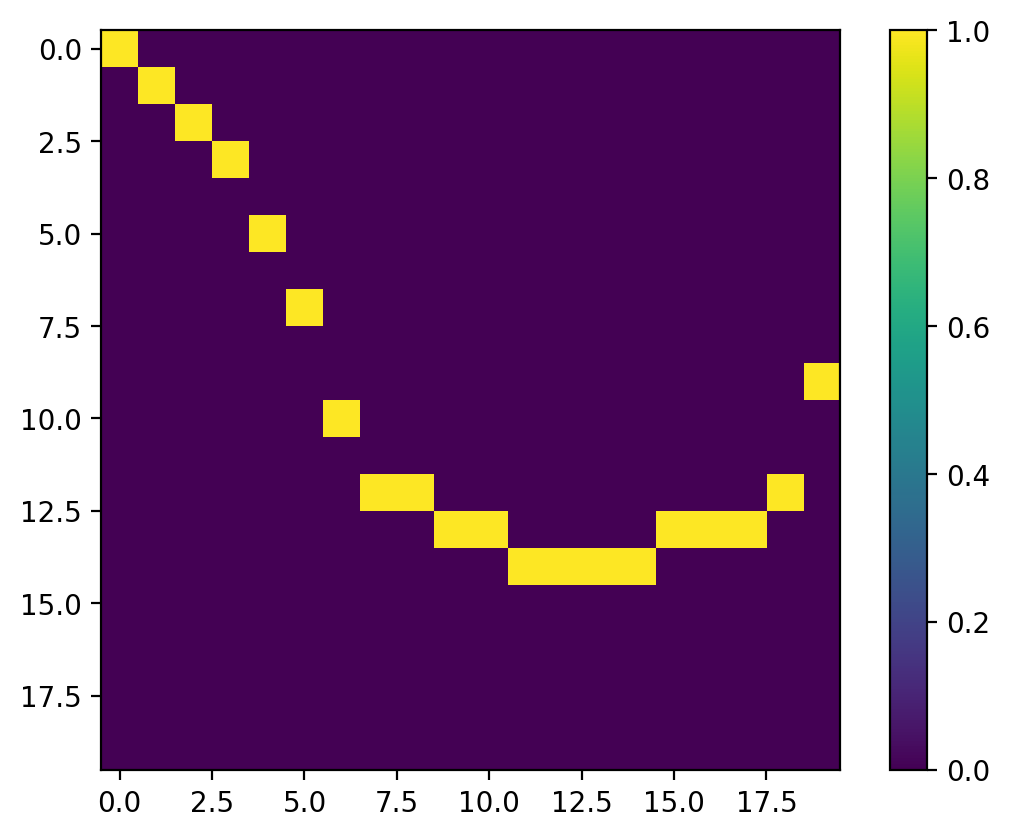

In [17]:
test_rot = FixedRot

npz = np.load("ode10x20.npz")
print(f"npz={npz['arr_0'].shape}")

ang_n = 10
ang = pi/ang_n
dataset1 = test_rot(npz['arr_0'], N=10, train=True, size=(DIM,DIM), angle=pi)

data, data_rot = dataset1.__getitem__(9)

imshow(data.squeeze())
colorbar()

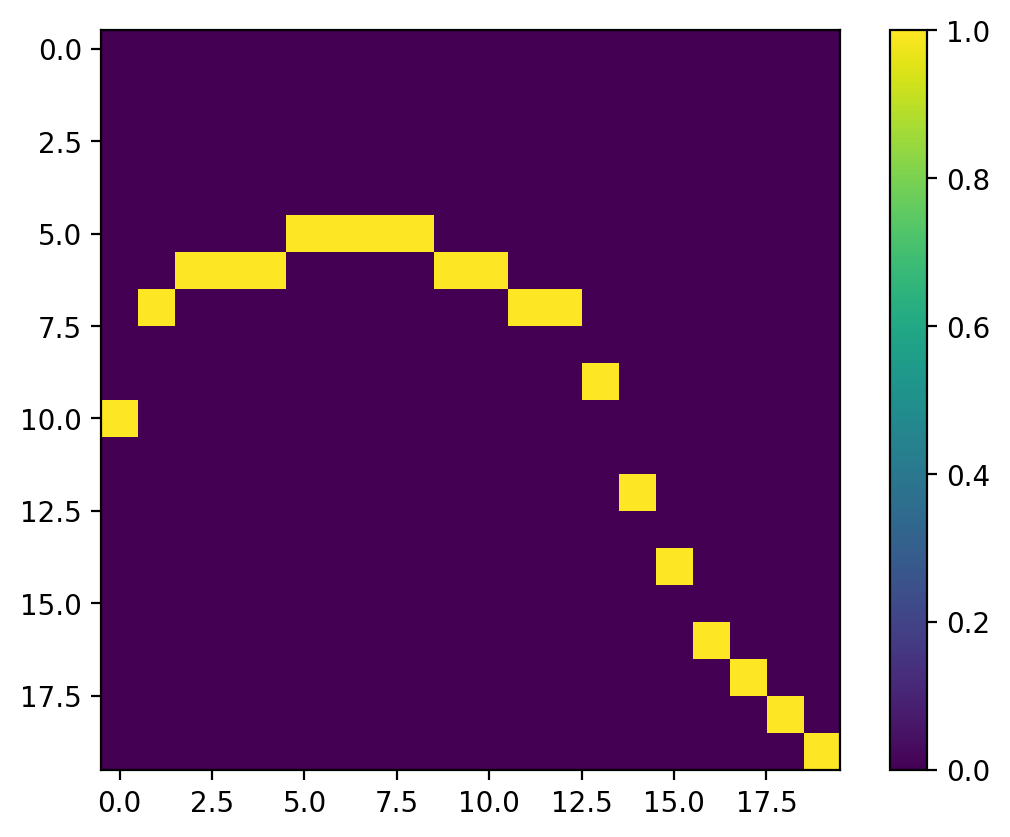

In [18]:
imshow(data_rot.squeeze())
colorbar()